<a href="https://colab.research.google.com/github/Chiebukar/Deep-Learning/blob/main/classification_of_natural_images_with_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

In [69]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list -s natural

Getting Dataset

In [71]:
# Download Dataset
!kaggle datasets download -d prasunroy/natural-images 

 96% 328M/342M [00:01<00:00, 171MB/s]
100% 342M/342M [00:02<00:00, 179MB/s]


In [72]:
# View downloaded files
!ls -d $PWD/*

 /content/~.
 /content/data
'/content/kaggle (1).json'
 /content/kaggle.json
 /content/natural_images
 /content/natural-images.zip
 /content/sample_data
 /content/using-basic-cnn-for-natural-image-classification.ipynb


In [ ]:
# Unzip files
!unzip \*.zip && rm *.zip

In [90]:
!ls -d $PWD/natural_images/*

/content/natural_images/airplane  /content/natural_images/flower
/content/natural_images/car	  /content/natural_images/fruit
/content/natural_images/cat	  /content/natural_images/motorbike
/content/natural_images/dog	  /content/natural_images/person


Import Required Libraries

In [113]:
import os
import numpy as np
from IPython.display import display, Image
import cv2
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow import keras
from  keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

%matplotlib inline

In [92]:
# displaying the different image classes
file_path = '/content/natural_images/'
labels = os.listdir(file_path)
labels

['person', 'car', 'airplane', 'cat', 'fruit', 'motorbike', 'dog', 'flower']



Visualizing images from the folders.



person
There are 986 images in person folder


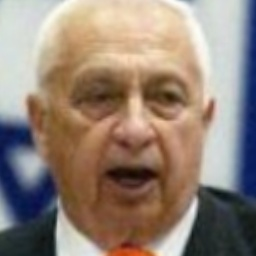

car
There are 968 images in car folder


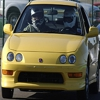

airplane
There are 727 images in airplane folder


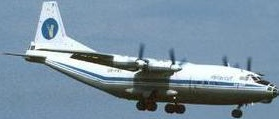

cat
There are 885 images in cat folder


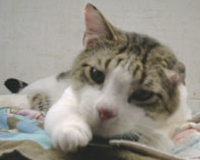

fruit
There are 1000 images in fruit folder


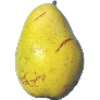

motorbike
There are 788 images in motorbike folder


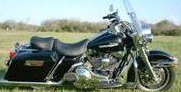

dog
There are 702 images in dog folder


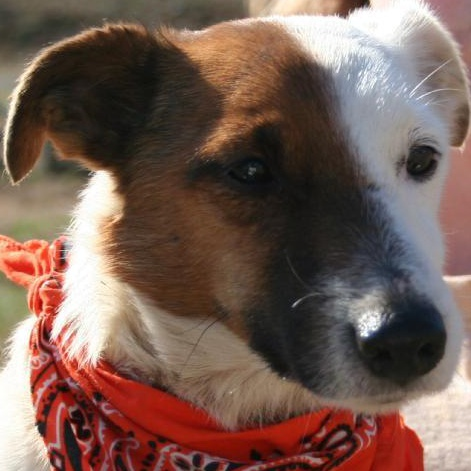

flower
There are 843 images in flower folder


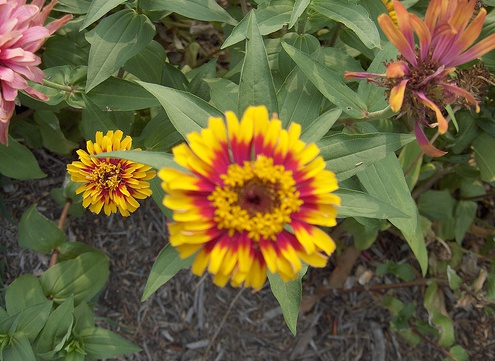

In [93]:
# displying the first image in each folder

for label in labels:
  folder_path = (file_path + '{0}/').format(label)
  imgs_path = os.listdir(folder_path)
  print(label)
  num = len(imgs_path)
  print('There are {} images in {} folder'.format(num,label))
  display(Image((folder_path+imgs_path[0])))

  


  


In [94]:
# get features and labels
features = []
targets = []

for label in labels:
  folder_path = (file_path + '{}/'.format(label))
  imgs_path = os.listdir(folder_path)
  for path in imgs_path:
    image = cv2.imread(folder_path+path)
    resized_image = cv2.resize(image, (32,32))
    features.append(np.array(resized_image))
    targets.append(label)

In [95]:
features= np.array(features)
features.shape

(6899, 32, 32, 3)

In [96]:
targets = np.array(targets)
targets.shape

(6899,)

Data Preprocessing

In [97]:
# Normalising the features
features = features.astype('float')/255

In [98]:
# Encoding the labels to numerals
encoder = LabelEncoder()
encoded_targets = encoder.fit_transform(targets)
np.unique(encoded_targets)


array([0, 1, 2, 3, 4, 5, 6, 7])

In [99]:
# categorise the numerical column
targets = to_categorical(encoded_targets)
targets[:5]

array([[0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [100]:
# shuffle features and labels.
idx = np.arange(features.shape[0])
np.random.seed(0)
np.random.shuffle(idx)
features = features[idx]
targets = targets[idx]

In [101]:
# split data into training and testing set
train_data, test_data, train_label, test_label = train_test_split(features, targets, test_size = 0.25)

In [102]:
# View shape of the different sets
train_data.shape, train_label.shape, test_data.shape, test_label.shape

((5174, 32, 32, 3), (5174, 8), (1725, 32, 32, 3), (1725, 8))

Model building, compiling and fitting

In [103]:
# Build model
def build_model():
  model = Sequential()

  model.add(Conv2D(filters= 32, kernel_size= (3,3), activation='relu', input_shape=(train_data.shape[1:])))
  model.add(MaxPool2D(2,2))

  model.add(Conv2D(filters= 64, kernel_size= (3,3), activation='relu'))
  model.add(MaxPool2D(2,2))

  model.add(Conv2D(filters= 128, kernel_size= (3,3), activation='relu'))
  model.add(MaxPool2D(2,2))

  model.add(Dropout(0.25))

  model.add(Flatten())

  model.add(Dense(units= 64, activation= 'relu'))

  model.add(Dense(units= 8, activation = 'softmax'))

  model.summary()
  model.compile(optimizer = 'rmsprop', loss= 'categorical_crossentropy', metrics= ['accuracy'])

  return model

In [104]:
# define folds for validation
kf = KFold(n_splits = 4)

In [ ]:
# Fit folds into model and save loss history
all_loss_history = []

for train_index, val_index in kf.split(train_data, train_label):
  x_train, y_train, x_val, y_val = train_data[train_index], train_label[train_index],train_data[val_index], train_label[val_index]
  model = build_model()
  history = model.fit(x_train, y_train, batch_size = 8, epochs= 20, validation_data= (x_val, y_val))
  val_loss_history = history.history['val_loss']
  all_loss_history.append(val_loss_history)

In [109]:
val_loss = np.array(all_loss_history)
val_loss.shape

(4, 20)

In [110]:
# aggregate validation history
epochs = val_loss.shape[1]
average_mae_history = [np.mean([x[i] for x in all_mae_history]) for i in range(epochs)]

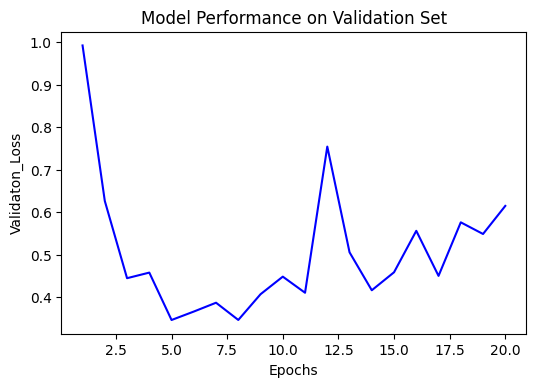

In [115]:
# Visualize model validtion loss history
plt.figure(dpi=100)
plt.plot(range(1, epochs+ 1), average_mae_history, 'b' )
plt.xlabel('Epochs')
plt.ylabel('Validaton_Loss')
plt.title ('Model Performance on Validation Set')
plt.show()

In [116]:
# Refit al data train data with parameters that optimizes model
model = build_model()
model.fit(train_data, train_label, epochs = 8, batch_size = 8) 

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 2, 2, 128)         0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 2, 2, 128)        

Model Evaluation and testing

In [123]:
# Predict with the test data
predictions = model.predict(test_data)
pred_labels = [np.argmax(pred) for pred in predictions] 
pred_labels[:5]

[2, 1, 1, 6, 0]

In [126]:
len(pred_labels)

1725

In [128]:
# convert test labels to single digits
test_label = np.argmax(test_label, axis=1)

In [129]:
# show model accuracy on test data
print('Accuracy score:', accuracy_score(test_label, pred_labels))

Accuracy score: 0.9043478260869565


Text(0.5, 33.0, 'Predicted')

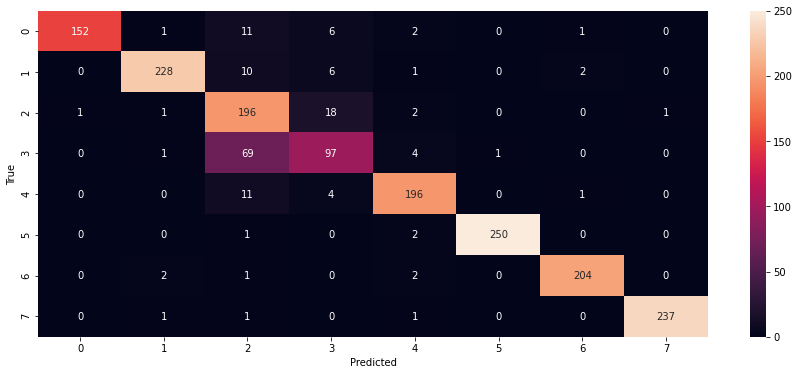

In [130]:
# Define and display confusion matrix
cm = confusion_matrix(test_label,pred_labels )

plt.figure(figsize = (15, 6))
sns.heatmap(cm, annot=True, fmt = 'd')
plt.ylabel('True')
plt.xlabel('Predicted')

